In [1]:
from planckmc.track_generation import halo_model
from planckmc.track_generation import make_tracks
from planckmc.detector_characteristics import DETECTOR_CHARACTERISTICS
from planckmc.response import sensor_response, RESPONSE_DICT
from planckmc.config import CONFIG
import numpy as np
from numba import njit, jit
%matplotlib inline
import matplotlib # plotting libraries
from matplotlib import animation, rc, cm
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.mplot3d import Axes3D

# import planckanalysis.integral_transform as pint
import planckanalysis.integral_transform_reworked as pint # This REQUIRES modified Padding
import multihist

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import numericalunits as nu
from scipy.stats import gaussian_kde
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from random import randrange, uniform

import json

#%pdb

C:\Users\bahaa\anaconda3\lib\site-packages\wimprates\halo.py:144: RuntimeWarning: divide by zero encountered in true_divide
  / (2 * v_earth_t * v))


In [2]:
#Essential Cell: Creates track and sensor accelerations (without noise) & developes varibale name standards

track=0

vel = halo_model.generate_vel_array(n_vels=1)
entry_vecs, exit_vecs, t_entry, t_exit = make_tracks.generate_tracks(vel, np.zeros(vel.shape))

sensors = tuple(DETECTOR_CHARACTERISTICS.keys())

lin_resp = RESPONSE_DICT[sensors[0]]['linear_response']
lin_resp_len = len(lin_resp)
floor_val = ((lin_resp_len - (((t_exit - t_entry) * 10**7) + 2)) // 2) + 1

if floor_val > 1:
    n_pad_strt = randrange(floor_val, floor_val + 200)
    n_pad_end = randrange(floor_val, floor_val + 200)
else:
    floor_val = 1
    n_pad_strt = randrange(floor_val, floor_val + 200)
    n_pad_end = randrange(floor_val, floor_val + 200)

# Acceleration without noise:
out = make_tracks.generate_acceleration_dict(entry_vecs, exit_vecs, t_entry, t_exit, {'M':1e10, 'G':6.67e-11}, strt_padding=n_pad_strt, end_padding=n_pad_end)

# Check: Helpful for when n_pad_strt & n_pad_end vary to check for sizes of arrays
sensor_response(sensors[0], out[0][sensors[0]]), np.linalg.norm(exit_vecs - entry_vecs), n_pad_strt, n_pad_end, len(out[track]['time'])

(array([[32671, 32684, 32723],
        [32669, 32683, 32724],
        [32667, 32682, 32725],
        ...,
        [32807, 32804, 32758],
        [32805, 32803, 32758],
        [32804, 32803, 32758]], dtype=int64),
 6.823794413328211,
 506,
 417,
 1110)

In [3]:
# Essential Initial Step for Noise Creation: Generates associated adc values (with added noise) to accelerations
# Essential for Noise Creation: Takes adc values and returns associated accelerations with noise

full_data_1 = np.array([[0] * 3 for i in range(len(out[track]['time']))])
full_data = np.array([full_data_1 for j in range(len(sensors))])
tm_vals = []

for sensrs in range(0,len(sensors)):
    x = sensor_response(sensors[sensrs], out[track][sensors[sensrs]])
    for tms in range(0,len(out[track]['time'])):
        for dim in range(0,len(x[tms])):
            # adc with noise
            full_data[sensrs][tms][dim] = x[tms][dim]

with open('response.json') as file:
  data = json.load(file)

m = np.array(data[sensors[0]]['signal_transfer_response'])

# Acceleration with noise
accels_w_noise = pint.adc_readout_to_accel(full_data, np.concatenate([[-np.inf], m[:-1]+np.diff(m)/2, [np.inf]]))

In [4]:
# Essential: Assigns the acceleration variables to the names used in the analysis (can be assigned above; correct naming is important)
# Necessary: Creates important variables and displays roughly how many samples will run in transform (KEEP in this ORDER)

time = out[track]['time']-out[track]['time'][0]

# FOR padding:
tm_steps = 10 #1
tmstep_strt = 0
tmstep_end = len(time)

# For NO padding:
#tm_steps = len(time)
#tmstep_strt = n_pad_strt - 1
#tmstep_end = len(time) - n_pad_end + 1

accels = []
accels_noise = []
sensors_pos = []
cnt = 0

for key in out[track]:
    if key not in ['time', 'particle_location']:
        accels.append(out[track][sensors[cnt]])
        accels_noise.append(accels_w_noise[cnt])
        sensors_pos.append(DETECTOR_CHARACTERISTICS[key]['position'])
        cnt += 1
        #print(key)

N_Analyses = 0
rn_step_indctr = []
for rn_stps in range(tmstep_strt, tmstep_end, tm_steps):
    rn_step_indctr.append(rn_stps)
print(len(rn_step_indctr))

111


In [5]:
# Function for Spatial Analysis (generates the relative thetas)

def py_ang(v1, v2):
    # Returns the angle in radians between vectors 'v1' and 'v2'
    cosdata = np.dot(v1, v2)
    denominator = np.linalg.norm(v1)*np.linalg.norm(v2)
    cosang = cosdata/denominator
    
    return cosang

In [6]:
# Essential: Entry and Exit Time Analysis (Blind)
# Generates the alphas with x_0, y_0, z_0 and x_1, y_1, z_1 

def Time_Analysis(entry_vecs, exit_vecs, n_pad_strt, n_pad_end, N_Analyses):
    velocity = [vel]
    alphas = []

    for vel_p in velocity:
        x_0 = out[track]['particle_location'][n_pad_strt][0]
        y_0 = out[track]['particle_location'][n_pad_strt][1]
        z_0 = out[track]['particle_location'][n_pad_strt][2]
        x_1 = out[track]['particle_location'][-1 - (n_pad_end)][0]
        y_1 = out[track]['particle_location'][-1 - (n_pad_end)][1]
        z_1 = out[track]['particle_location'][-1 - (n_pad_end)][2]
        length = np.sqrt(
            (x_1-x_0)**2 +
            (y_1-y_0)**2 +
            (z_1-z_0)**2
        )
        alphas.append([
            x_0,
            y_0,
            z_0,
            0,
            x_1,
            y_1,
            z_1,
            length/vel_p,
        ])
    
    N_Analyses += 1
    return alphas

In [7]:
# Essential: Velocity Analysis

def Velocity_Analysis(entry_vecs, exit_vecs, n_pad_strt, n_pad_end, N_Analyses):
    velocity_bins = np.linspace(1e5,7e5,250)
    velocity_bin_centres = velocity_bins[:-1] + np.diff(velocity_bins)/2
    alphas = []

    for vel_p in velocity_bin_centres:
        x_0 = entry_vecs[0]
        y_0 = entry_vecs[1]
        z_0 = entry_vecs[2]
        x_1 = exit_vecs[0]
        y_1 = exit_vecs[1]
        z_1 = exit_vecs[2]
        length = np.sqrt(
            (x_1-x_0)**2 +
            (y_1-y_0)**2 +
            (z_1-z_0)**2
        )
        alphas.append([
            x_0,
            y_0,
            z_0,
            0,
            x_1,
            y_1,
            z_1,
            length/vel_p,
        ])
    
    N_Analyses += 1
    return alphas

In [8]:
# Spatial Analysis

def Theta_Analysis(vel, entry_vecs, exit_vecs, n_pad_strt, n_pad_end, N_Analyses, radius = float(CONFIG['Track Generation']['BoundingSphereRadius'])):
    thetas = np.linspace(0,90,90)
    theta_cos_val = []
    vel_p = vel
    alphas = []
    alpharange = []
    alpha1 = exit_vecs - entry_vecs
    alpha = np.array([alpha1[0][0],alpha1[1][0],alpha1[2][0]]) #redefine/restructure alpha
    
    for i in thetas: 
        x_0 = entry_vecs[0]
        y_0 = entry_vecs[1]
        z_0 = entry_vecs[2]

        coordinates = make_tracks.sample_spherical(ndim=3, n_vecs=1)
        x_1 = coordinates[0][0]*radius
        y_1 = coordinates[1][0]*radius
        z_1 = coordinates[2][0]*radius
        length = np.sqrt(
            (x_1-x_0)**2 +
            (y_1-y_0)**2 +
            (z_1-z_0)**2
        )
        ydiff = y_1 - y_0
        xdiff = x_1 - x_0
        zdiff = z_1 - z_0

        alphas.append([
            x_0,
            y_0,
            z_0,
            0,
            x_1,
            y_1,
            z_1,
            length/vel_p,
        ])

        alphaprime = np.array([xdiff,ydiff,zdiff])
        alpharange.append(alphaprime)

        #costheta = np.dot(alpha, alphaprime)/(np.linalg.norm(alpha))*(np.linalg.norm(alphaprime))
        #theta = np.arccos(costheta)
        costheta = py_ang(alphaprime.T, alpha.T)
        theta_cos_val.append(costheta)
        
    N_Analyses += 1
    return alphas, theta_cos_val

In [9]:
# analysis_parameter = np.zeros(len(N_Analyses))
analysis_parameter = []

# BELOW HERE: UNCOMMENT the analysis parameter(s) wanted for the analysis (two lines each)

alphas = Time_Analysis(entry_vecs, exit_vecs, n_pad_strt, n_pad_end, N_Analyses)
analysis_parameter.append('Time')

# alphas = Velocity_Analysis(entry_vecs, exit_vecs, n_pad_strt, n_pad_end, N_Analyses)
# analysis_parameter.append('Velocity')

# alphas, theta_cos_val = Theta_Analysis(vel, entry_vecs, exit_vecs, n_pad_strt, n_pad_end, N_Analyses, radius = float(CONFIG['Track Generation']['BoundingSphereRadius']))
# analysis_parameter.append('Theta_Space')

In [15]:
def transform_operation(time, tm_steps, tmstep_strt, tmstep_end, accels, alphas, sensors_pos, lin_resp):
    timestep_indices = np.array(range(tmstep_strt, tmstep_end, tm_steps))
    timesteps = time[timestep_indices]

    #transformed_data = pint.transform(time/1e9, accels, timesteps/1e9, timestep_indices, np.array(alphas), sensors_pos)
    
    # With integral_transform_reworked
    transformed_data = pint.transform(time/1e9, accels, timesteps/1e9, timestep_indices, np.array(alphas), sensors_pos, lin_resp)
    return transformed_data

In [16]:
def transform_operation_noise(time, tm_steps, tmstep_strt, tmstep_end, accels_noise, alphas, sensors_pos, lin_resp):
    timestep_indices = np.array(range(tmstep_strt, tmstep_end, tm_steps))
    timesteps = time[timestep_indices]

    #transformed_data = pint.transform(time/1e9, accels_noise, timesteps/1e9, timestep_indices, np.array(alphas), sensors_pos)

    # With integral_transform_reworked
    transformed_data = pint.transform(time/1e9, accels_noise, timesteps/1e9, timestep_indices, np.array(alphas), sensors_pos, lin_resp)
    return transformed_data

In [17]:
# Necessary: Runs integral transform given the times, accelerations, alphas, and sensor positions
# Transform gives back S, Snorm, and the two four-vectors (x,y,z,t) for all the entry and exit points in the analysis

if tm_steps == len(time) and (tmstep_strt != n_pad_strt - 1 or tmstep_end != len(time) - n_pad_end + 1):
    raise ValueError("You are only analyzing 1 time step, but you also are considering the padding. Please input correct values")
else:
    transformed_data = transform_operation(time, tm_steps, tmstep_strt, tmstep_end, accels, alphas, sensors_pos, np.array(lin_resp))

100%|██████████| 111/111 [12:40<00:00,  6.85s/it] 


In [18]:
# Necessary: Runs integral transform given the times, accelerations with noise, alphas, and sensor positions
# Transform has the same format as the cell above

if tm_steps == len(time) and (tmstep_strt != n_pad_strt - 1 or tmstep_end != len(time) - n_pad_end + 1):
    raise ValueError("You are only analyzing 1 time step, but you also are considering the padding. Please input correct values")
else:
    transformed_data_noise = transform_operation_noise(time, tm_steps, tmstep_strt, tmstep_end, accels_noise, alphas, sensors_pos, np.array(lin_resp))

100%|██████████| 111/111 [13:50<00:00,  7.48s/it] 


In [19]:
# Shows the result of transform
transformed_data

array([(-0.18888594, -0.00101552, 4.82778074, 0.55261663, -1.85125578, 0.00e+00, 0.15322416, 5.19879448, -0.07402238, 1.860e-05,  186),
       (-0.22401161, -0.00120436, 4.82778074, 0.55261663, -1.85125578, 1.00e-06, 0.15322416, 5.19879448, -0.07402238, 1.960e-05,  186),
       (-0.24144437, -0.00129809, 4.82778074, 0.55261663, -1.85125578, 2.00e-06, 0.15322416, 5.19879448, -0.07402238, 2.060e-05,  186),
       (-0.24173677, -0.00129966, 4.82778074, 0.55261663, -1.85125578, 3.00e-06, 0.15322416, 5.19879448, -0.07402238, 2.160e-05,  186),
       (-0.21922464, -0.00117863, 4.82778074, 0.55261663, -1.85125578, 4.00e-06, 0.15322416, 5.19879448, -0.07402238, 2.260e-05,  186),
       (-0.17899365, -0.00096233, 4.82778074, 0.55261663, -1.85125578, 5.00e-06, 0.15322416, 5.19879448, -0.07402238, 2.360e-05,  186),
       (-0.11934396, -0.00064163, 4.82778074, 0.55261663, -1.85125578, 6.00e-06, 0.15322416, 5.19879448, -0.07402238, 2.460e-05,  186),
       (-0.04323011, -0.00023242, 4.82778074, 0.

In [20]:
# Shows the track associated with the largest Snorm (S) value
transformed_data[np.argmax(transformed_data['S_norm'])]

(0.07873261, 0.00984158, 4.82778074, 0.55261663, -1.85125578, 2.6e-05, 0.15322416, 5.19879448, -0.07402238, 4.46e-05, 8)

In [21]:
# Format: variable = np.array(transformed_data['variable_name'])

Snorm_data_plt = np.array(transformed_data['S_norm'])
S_data_plt = np.array(transformed_data['S'])

# Calculate variable from the standard varaibles of transform if necessary (e.g. theta from the cartesian coordinates)

tm_strt_plt = np.array(transformed_data['alpha0_t'])
tm_end_plt = np.array(transformed_data['alpha1_t'])
vel_plt = np.array(np.sqrt((transformed_data['alpha1_x'] - transformed_data['alpha0_x'])**2 +
                   (transformed_data['alpha1_y'] - transformed_data['alpha0_y'])**2 +
                   (transformed_data['alpha1_z'] - transformed_data['alpha0_z'])**2) / (transformed_data['alpha1_t'] - transformed_data['alpha0_t']))
if 'Theta_Space' in analysis_parameter:
    theta_cos_plt = theta_cos_val
    theta_plt = np.arccos(theta_cos_val)
else:
    theta_cos_plt = np.ones(len(S_data_plt))
    theta_plt = np.zeros(len(S_data_plt))

In [22]:
# Format: variable_noise = np.array(transformed_data_noise['variable_name'])

Snorm_data_plt_noise = np.array(transformed_data_noise['S_norm'])
S_data_plt_noise = np.array(transformed_data_noise['S'])

# Calculate variable from the standard varaibles of transform if necessary (e.g. theta from the cartesian coordinates)

tm_strt_plt_noise = np.array(transformed_data_noise['alpha0_t'])
tm_end_plt_noise = np.array(transformed_data_noise['alpha1_t'])
vel_plt_noise = np.array(np.sqrt((transformed_data_noise['alpha1_x'] - transformed_data_noise['alpha0_x'])**2 +
                                 (transformed_data_noise['alpha1_y'] - transformed_data_noise['alpha0_y'])**2 +
                                 (transformed_data_noise['alpha1_z'] - transformed_data_noise['alpha0_z'])**2) / (transformed_data_noise['alpha1_t'] - transformed_data_noise['alpha0_t']))

In [23]:
# Full width Half Maximum Calculations

hf_max_S = np.max(transformed_data['S']) / 2
hf_max_Snorm = np.max(transformed_data['S_norm']) / 2

# Prominence (Maximum) Determination: Direct Assignment is possible; peak_prominences allows for calculations of correct left and right bases
prominence_info = peak_prominences(x=transformed_data['S'], peaks=[np.argmax(transformed_data['S'])])
prominence = [np.array([np.max(transformed_data['S'])]), prominence_info[1], prominence_info[2]]

# Fwhm Calculation:
fwhm_data = peak_widths(x=transformed_data['S'], peaks=[np.argmax(transformed_data['S'])], rel_height=0.5, prominence_data=prominence)

# Output of function: widths of each each peak in samples (# of indices), width heights (height of where widths are determined),
#                     left interpolated position (left-most index of full-width), right interpolated position (Right-most index of full-width)

In [27]:
tm_strt_plt * 10**6

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110.])

In [29]:
(n_pad_strt - 1) / 10

50.5


 # of indices =  12 , fwhm =  12.0
-----------------------------------------------------------


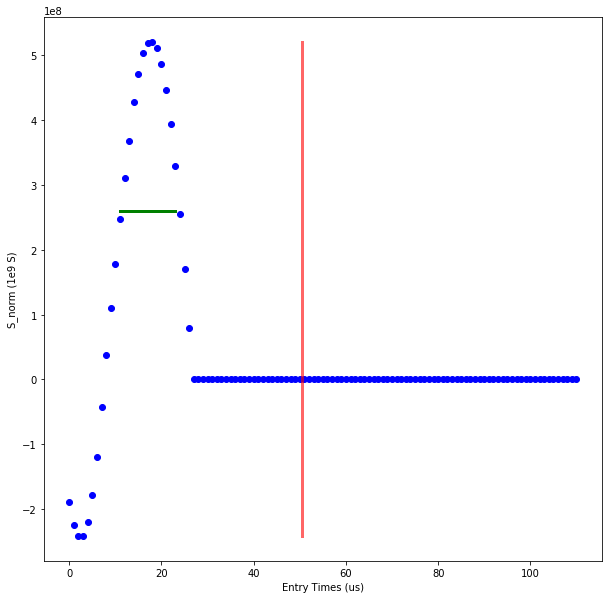

In [53]:
X_Val1 = [(n_pad_strt - 1) / 10, (n_pad_strt - 1) / 10] # Actual Variable Value of Track
Y_Val1 = [min(S_data_plt) * 10**9, max(S_data_plt) * 10**9] # If plotting S -> min & max of S_data_plt, If plotting Snorm -> min & max of Snorm_data_plt


fig1 = plt.figure(figsize=[10,10])
plt.plot(tm_strt_plt * 10**6, S_data_plt * 10**9, 'bo', alpha=1) # Input variable as the X axis & S or Snorm for the y axis
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.plot([tm_strt_plt[int(fwhm_data[2])] * 10**6, tm_strt_plt[int(fwhm_data[3])] * 10**6], [hf_max_S * 10**9, hf_max_S * 10**9], 'g', alpha=1, linewidth = 3)
print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(tm_strt_plt[int(fwhm_data[2])] - tm_strt_plt[int(fwhm_data[3])]) * 10**6)
print('-----------------------------------------------------------')

#plt.xlim(t_entry * 10**6, t_entry * 10**6 + n_pad_strt / 10 + t_exit  * 10**6 + n_pad_end / 10) # Put ranges if necessary, careful of padding
plt.ylabel('S_norm (1e9 S)')
plt.xlabel('Entry Times (us)')
plt.show()

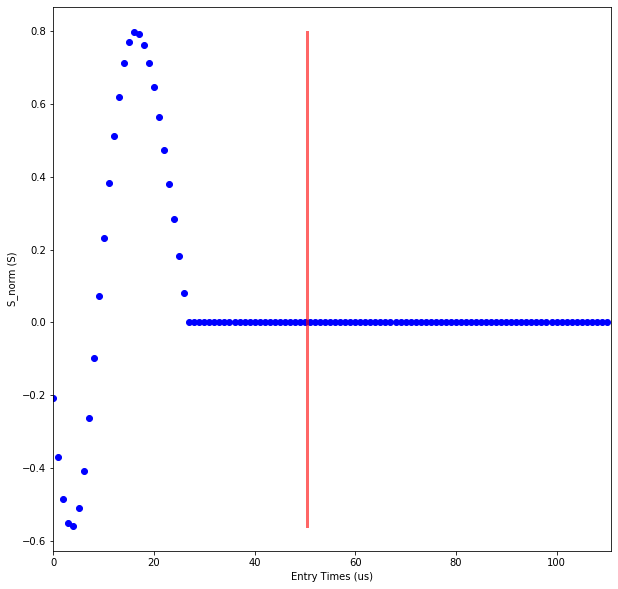

In [34]:
# Same format as above, plotting with noise instead

X_Val1 = [(n_pad_strt - 1) / 10, (n_pad_strt - 1) / 10] # Actual Variable Value of Track
Y_Val1 = [min(S_data_plt_noise), max(S_data_plt_noise)]

fig2 = plt.figure(figsize=[10,10])
plt.plot(tm_strt_plt_noise * 10**6, S_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.xlim(t_entry * 10**6, t_entry * 10**6 + n_pad_strt / 10 + t_exit  * 10**6 + n_pad_end / 10) # Put ranges if necessary, careful of padding
plt.ylabel('S_norm (S)')
plt.xlabel('Entry Times (us)')
plt.show()


 # of indices =  12 , fwhm =  11.999999999999996
-----------------------------------------------------------


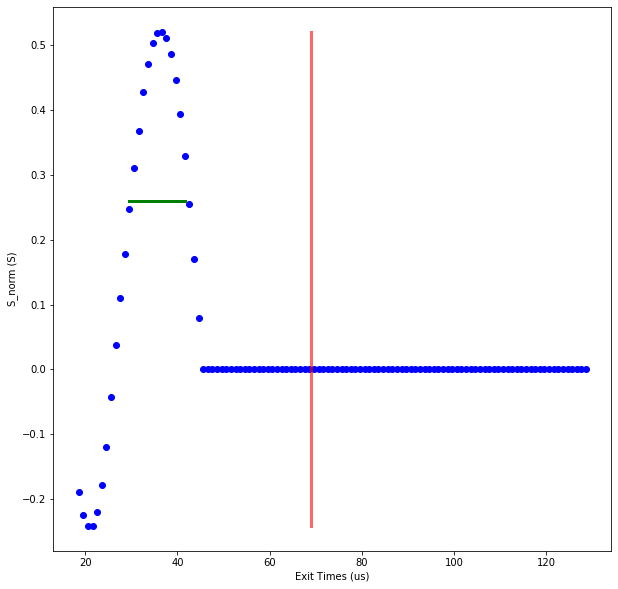

In [35]:
X_Val1 = [(((out[track]['time'][-1] - (n_pad_end + 1) * 100) / 1000) + ((n_pad_strt - 1) / 10)), (((out[track]['time'][-1] - (n_pad_end + 1) * 100) / 1000) + ((n_pad_strt - 1) / 10))]
Y_Val1 = [min(S_data_plt), max(S_data_plt)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(tm_end_plt * 10**6, S_data_plt, 'bo', alpha=1)

plt.plot([tm_end_plt[int(fwhm_data[2])] * 10**6, tm_end_plt[int(fwhm_data[3])] * 10**6], [hf_max_S, hf_max_S], 'g', alpha=1, linewidth = 3)
print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(tm_end_plt[int(fwhm_data[2])] - tm_end_plt[int(fwhm_data[3])]) * 10**6)
print('-----------------------------------------------------------')

plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)
#plt.xlim(t_entry * 10**6, t_entry * 10**6 + n_pad_strt / 10 + t_exit  * 10**6 + n_pad_end / 10) # Put ranges if necessary, careful of padding
plt.ylabel('S_norm (S)')
plt.xlabel('Exit Times (us)')
plt.show()


 # of indices =  12 , fwhm =  11.999999999999996
-----------------------------------------------------------


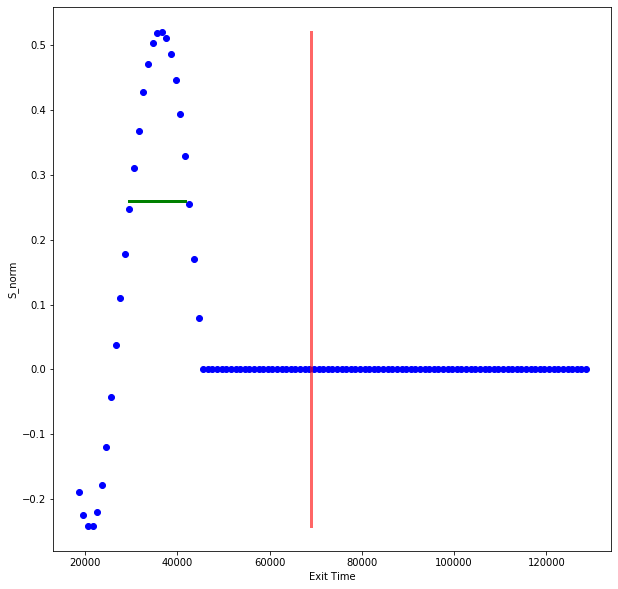

In [36]:
X_Val1 = [out[track]['time'][-1] - (n_pad_end + 1) * 100 + (n_pad_strt -1) * 100, out[track]['time'][-1] - (n_pad_end + 1) * 100 + (n_pad_strt -1) * 100]
Y_Val1 = [min(S_data_plt), max(S_data_plt)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(tm_end_plt * 10**9, S_data_plt, 'bo', alpha=1)

plt.plot([tm_end_plt[int(fwhm_data[2])] * 10**9, tm_end_plt[int(fwhm_data[3])] * 10**9], [hf_max_S, hf_max_S], 'g', alpha=1, linewidth = 3)
print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(tm_end_plt[int(fwhm_data[2])] - tm_end_plt[int(fwhm_data[3])]) * 10**6)
print('-----------------------------------------------------------')

plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)
#plt.yscale('log')
plt.ylabel('S_norm')
plt.xlabel('Exit Time')
plt.show()


 # of indices =  12 , fwhm =  5.820766091346741e-14
-----------------------------------------------------------


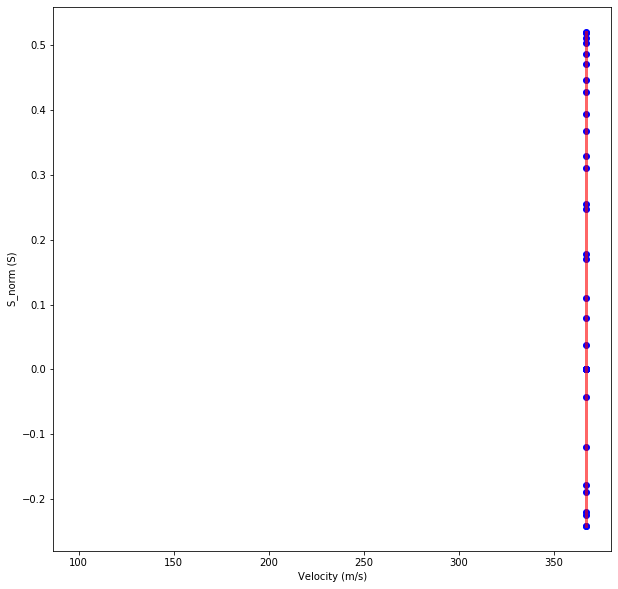

In [37]:
X_Val1 = [vel/1000, vel/1000]
Y_Val1 = [min(S_data_plt), max(S_data_plt)]

fig4 = plt.figure(figsize=[10,10])
plt.plot(vel_plt/1000, S_data_plt, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

vel_step = vel_plt[1] - vel_plt[0]

plt.plot([1e2 + fwhm_data[2] * vel_step / 1000, 1e2 + fwhm_data[3] * vel_step / 1000], [hf_max_S, hf_max_S], 'g', alpha=1, linewidth = 3)
print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(vel_plt[int(fwhm_data[2])] - vel_plt[int(fwhm_data[3])])/1000)
print('-----------------------------------------------------------')

plt.ylabel('S_norm (S)')
plt.xlabel('Velocity (m/s)')
plt.show()

In [38]:
# Values of the Velocity Analysis and Plotting

print(fwhm_data[2] * vel_step / 1000, vel_plt[int(fwhm_data[2])] / 1000)
print(1e2 + (np.argmax(transformed_data['S'])) * vel_step / 1000)
print(vel/1000)
print(vel_step/1000)

[0.] 367.0
100.0
[367.]
0.0


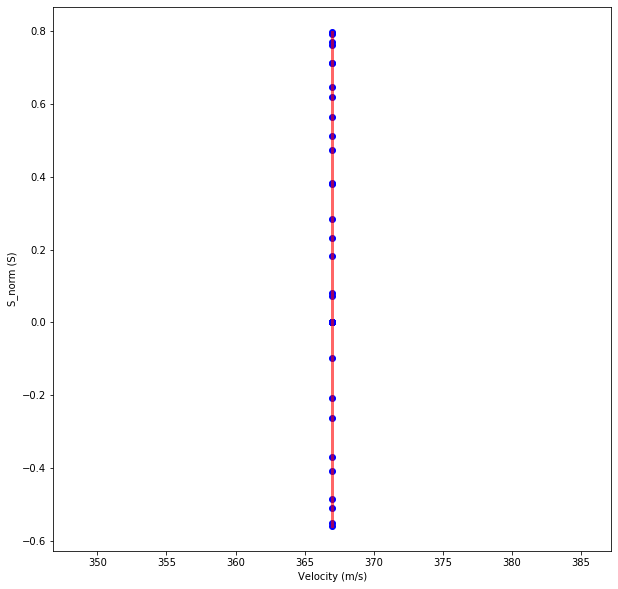

In [39]:
X_Val1 = [vel/1000, vel/1000]
Y_Val1 = [min(S_data_plt_noise), max(S_data_plt_noise)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(vel_plt_noise/1000, S_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)
#plt.plot(X_Val2, Y_Val1, 'g', alpha=0.6, linewidth = 3)
#plt.yscale('log')
plt.ylabel('S_norm (S)')
plt.xlabel('Velocity (m/s)')
plt.show()


 # of indices =  12 , fwhm =  0.0
-----------------------------------------------------------


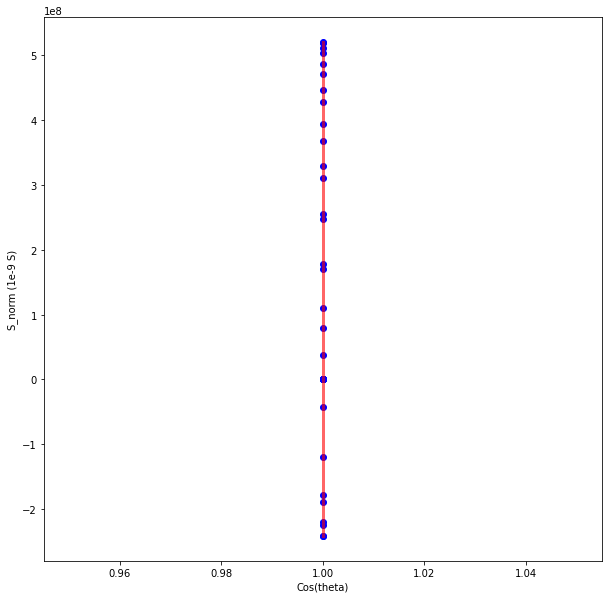

In [40]:
X_Val1 = [1, 1] # plotting cos theta values
Y_Val1 = [min(S_data_plt) * 10**9, max(S_data_plt) * 10**9]

fig3 = plt.figure(figsize=[10,10])
plt.plot(theta_cos_plt, S_data_plt * 10**9, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.plot([theta_cos_plt[int(fwhm_data[2])], theta_cos_plt[int(fwhm_data[3])]], [hf_max_S * 10**9, hf_max_S * 10**9], 'g', alpha=1, linewidth = 3)
print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(theta_cos_plt[int(fwhm_data[2])] - theta_cos_plt[int(fwhm_data[3])]))
print('-----------------------------------------------------------')

plt.ylabel('S_norm (1e-9 S)')
plt.xlabel('Cos(theta)')
plt.show()


 # of indices =  12 , fwhm =  0.0
-----------------------------------------------------------


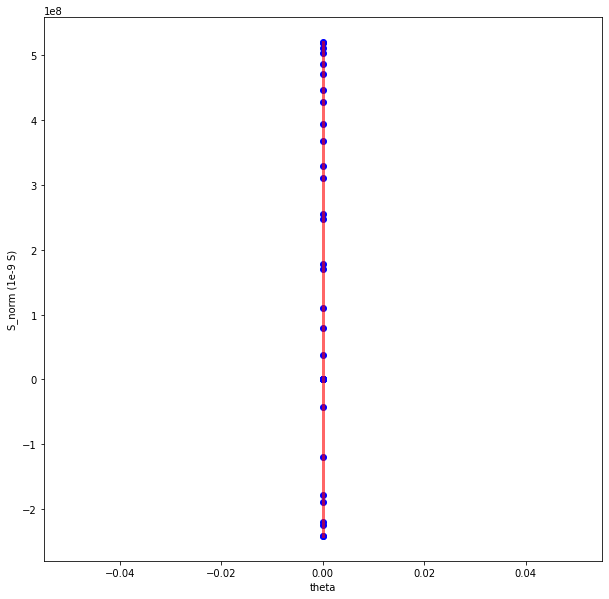

In [41]:
X_Val1 = [0, 0] # plotting theta values
Y_Val1 = [min(S_data_plt) * 10**9, max(S_data_plt) * 10**9]

fig3 = plt.figure(figsize=[10,10])
plt.plot(theta_plt, S_data_plt * 10**9, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.plot([theta_plt[int(fwhm_data[2])], theta_plt[int(fwhm_data[3])]], [hf_max_S * 10**9, hf_max_S * 10**9], 'g', alpha=1, linewidth = 3)
print('\n # of indices = ', int(fwhm_data[0]), ', fwhm = ', abs(theta_plt[int(fwhm_data[2])] - theta_plt[int(fwhm_data[3])]))
print('-----------------------------------------------------------')

plt.ylabel('S_norm (1e-9 S)')
plt.xlabel('theta')
plt.show()

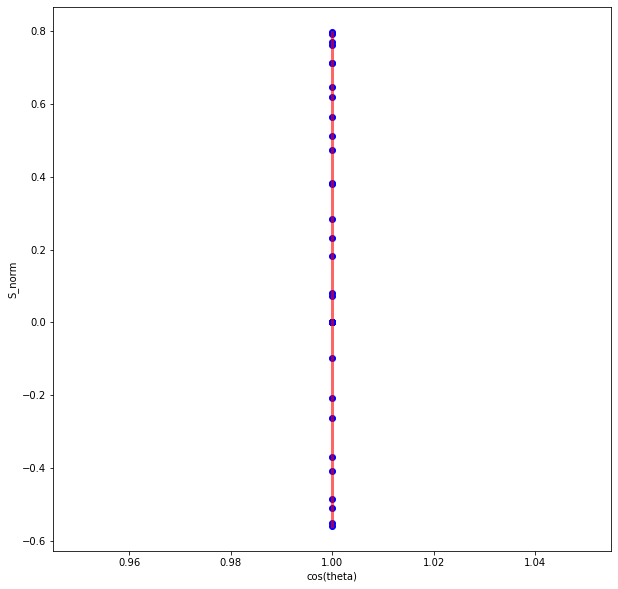

In [42]:
X_Val1 = [1, 1] # if plotting cos theta values
# X_Val1 = [0, 0] # if plotting theta values
Y_Val1 = [min(S_data_plt_noise), max(S_data_plt_noise)]

fig3 = plt.figure(figsize=[10,10])
plt.plot(theta_cos_plt, S_data_plt_noise, 'bo', alpha=1)
plt.plot(X_Val1, Y_Val1, 'r', alpha=0.6, linewidth = 3)

plt.ylabel('S_norm')
plt.xlabel('cos(theta)')
plt.show()